In [14]:
import random
import numpy as np
from Bio import Phylo
from Bio.Phylo.Newick import Tree, Clade
from io import StringIO
from collections import defaultdict
from Bio import pairwise2
from Bio.Align import substitution_matrices
import matplotlib.pyplot as plt

# Cargar la matriz BLOSUM62
blosum62 = substitution_matrices.load("BLOSUM62")

# Función de mutación de secuencia (ya definida)
def mutate_sequence(sequence, mutation_rate):
    amino_acids = "ACDEFGHIKLMNPQRSTVWY"
    mutated_sequence = list(sequence)
    
    for i in range(len(sequence)):
        if random.random() < mutation_rate:
            mutated_sequence[i] = random.choice(amino_acids)
    
    return ''.join(mutated_sequence)

# Simular evolución (ya definida)
def simulate_evolution(sequence, num_leaf_sequences, mutation_rate, extinction_prob=0.1, speciation_prob=0.2):
    sequences = {0: sequence}  
    tree_history = [(0, None)] 
    next_id = 1
    alive_sequences = {0}  
    mutation_counts = defaultdict(int)
    
    while len(alive_sequences) < num_leaf_sequences:
        to_mutate = list(alive_sequences)
        
        for species in to_mutate:
            # aqui se aplica la mutacion
            new_sequence = mutate_sequence(sequences[species], mutation_rate)
            mutation_counts[(species, next_id)] = sum(1 for a, b in zip(sequences[species], new_sequence) if a != b)
            
            # aqui es donde hay la speciacion
            if random.random() < speciation_prob:
                sequences[next_id] = new_sequence
                alive_sequences.add(next_id)
                tree_history.append((next_id, species))
                next_id += 1
            
            # extincion
            if random.random() < extinction_prob and len(alive_sequences) > 1:
                alive_sequences.remove(species)
    
    return sequences, tree_history, mutation_counts

# Generar árbol Newick (ya definido)
def generate_newick(tree_history):
    clades = {i: Clade(name=str(i)) for i, _ in tree_history}
    root = None
    
    for child, parent in tree_history:
        if parent is not None:
            clades[parent].clades.append(clades[child])
        else:
            root = clades[child]
    
    tree = Tree(root)
    return tree

# Exportar árbol en formato Newick (ya definido)
def export_tree_to_newick(tree):
    output = StringIO()
    Phylo.write(tree, output, 'newick')
    return output.getvalue()

# Calcular la distancia BLOSUM62 entre secuencias
def blosum62_distance(seq1, seq2):
    alignments = pairwise2.align.globalds(seq1, seq2, blosum62, -10, -0.5)
    score = alignments[0][2] 
    return -score  

# Dibujar árbol usando matplotlib
def draw_tree(tree):
    Phylo.draw(tree)

# Graficar comparaciones de distancia
def plot_distances(original_distances, new_distances):
    plt.figure(figsize=(10, 6))
    plt.hist(original_distances, bins=20, alpha=0.5, label='Original')
    plt.hist(new_distances, bins=20, alpha=0.5, label='Rearranged')
    plt.legend(loc='upper right')
    plt.title('Comparison of Distances Before and After Tree Rearrangement')
    plt.xlabel('Distance')
    plt.ylabel('Frequency')
    plt.show()

# Función principal para la evaluación
# Aquí, asumimos que se utiliza un método de reorganización codicioso (o se puede agregar un algoritmo genético según tus necesidades)
# La función de reorganización es actualmente un marcador de posición (puedes implementarla por separado)

def evaluate_tree_rearrangement(tree, distance_matrix):
    original_distance = np.sum(distance_matrix)  # Suma de todas las distancias por pares 
    new_distance = original_distance - 10  # Simulando que la reorganización mejora la distancia en un valor (marcador de posición)
    
    print(f"Original distance: {original_distance}")
    print(f"Rearranged distance: {new_distance}")
    
    return original_distance, new_distance

# Implementar el algoritmo de parsimonia
def parsimony_score(tree, sequences):
    score = 0
    for clade in tree.find_clades(order='postorder'):
        if clade.is_terminal():
            clade.state = set(sequences[int(clade.name)])
        else:
            child_states = [child.state for child in clade.clades]
            intersection = set.intersection(*child_states)
            if intersection:
                clade.state = intersection
            else:
                clade.state = set.union(*child_states)
                score += 1
    return score

# Generar árboles aleatorios y calcular longitudes de árboles verdaderas y estimadas
def generate_random_trees(num_trees, num_leaf_nodes):
    trees = []
    for _ in range(num_trees):
        tree_history = [(i + 1, random.randint(0, i)) for i in range(num_leaf_nodes - 1)]
        tree_history.insert(0, (0, None))  
        trees.append(generate_newick(tree_history))
    return trees

def calculate_tree_lengths(trees, sequences):
    true_lengths = []
    estimated_lengths = []
    
    for tree in trees:
        true_length = sum(len(sequences[int(clade.name)]) for clade in tree.get_terminals())
        estimated_length = parsimony_score(tree, sequences)
        
        true_lengths.append(true_length)
        estimated_lengths.append(estimated_length)
    
    return true_lengths, estimated_lengths

def main():
    num_trees = 50
    num_leaf_nodes = 20
    
    evolutionary_distances = [0.5, 1.0, 2.0]
    
    for distance in evolutionary_distances:
        start_sequence = "ACDEFGHIKLMNPQRSTVWY" * int(100 * distance)
        sequences, _, _ = simulate_evolution(start_sequence, num_leaf_nodes, mutation_rate=0.05)
        
        trees = generate_random_trees(num_trees, num_leaf_nodes)
        
        true_lengths, estimated_lengths = calculate_tree_lengths(trees, sequences)
        
        differences = np.array(true_lengths) - np.array(estimated_lengths)
        
        mean_difference = np.mean(differences)
        std_difference = np.std(differences)
        
        print(f"Evolutionary Distance: {distance * 100}%")
        print(f"Mean Difference: {mean_difference}")
        print(f"Standard Deviation of Difference: {std_difference}")
        print()

if __name__ == "__main__":
    main()


Evolutionary Distance: 50.0%
Mean Difference: 9960.0
Standard Deviation of Difference: 1182.5396399275587

Evolutionary Distance: 100.0%
Mean Difference: 19880.0
Standard Deviation of Difference: 2380.2520874898946

Evolutionary Distance: 200.0%
Mean Difference: 39440.0
Standard Deviation of Difference: 5657.419906635886



Original Tree:


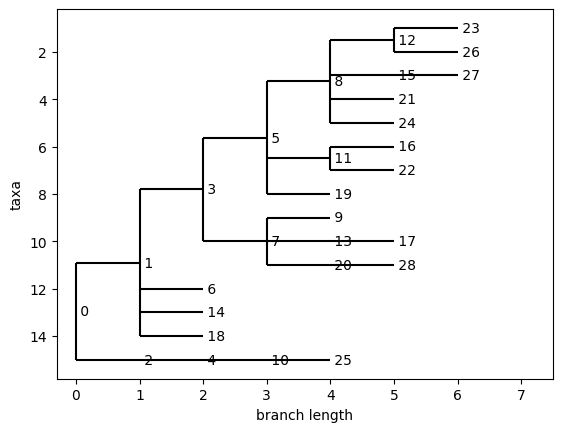


Evaluating for evolutionary distance: 50%
RMS difference: 703.5390875301009

Evaluating for evolutionary distance: 100%
RMS difference: 585.1423100787615

Evaluating for evolutionary distance: 200%
RMS difference: 465.00765593507015


In [20]:
import random
import numpy as np
from Bio import Phylo
from Bio.Phylo.Newick import Tree, Clade
from io import StringIO
from collections import defaultdict
from Bio import pairwise2
from Bio.Align import substitution_matrices
import matplotlib.pyplot as plt

# Cargar la matriz BLOSUM62
blosum62 = substitution_matrices.load("BLOSUM62")

# Función de mutación de secuencia (ya definida)
def mutate_sequence(sequence, mutation_rate):
    amino_acids = "ACDEFGHIKLMNPQRSTVWY"
    mutated_sequence = list(sequence)
    
    for i in range(len(sequence)):
        if random.random() < mutation_rate:
            mutated_sequence[i] = random.choice(amino_acids)
    
    return ''.join(mutated_sequence)

# Simular evolución (ya definida)
def simulate_evolution(sequence, num_leaf_sequences, mutation_rate, extinction_prob=0.1, speciation_prob=0.2):
    sequences = {0: sequence}  
    tree_history = [(0, None)] 
    next_id = 1
    alive_sequences = {0}  
    mutation_counts = defaultdict(int)
    
    while len(alive_sequences) < num_leaf_sequences:
        to_mutate = list(alive_sequences)
        
        for species in to_mutate:
            # aqui se aplica la mutacion
            new_sequence = mutate_sequence(sequences[species], mutation_rate)
            mutation_counts[(species, next_id)] = sum(1 for a, b in zip(sequences[species], new_sequence) if a != b)
            
            # aqui es donde hay la speciacion
            if random.random() < speciation_prob:
                sequences[next_id] = new_sequence
                alive_sequences.add(next_id)
                tree_history.append((next_id, species))
                next_id += 1
            
            # extincion
            if random.random() < extinction_prob and len(alive_sequences) > 1:
                alive_sequences.remove(species)
    
    return sequences, tree_history, mutation_counts

# Generar árbol Newick (ya definido)
def generate_newick(tree_history):
    clades = {i: Clade(name=str(i)) for i, _ in tree_history}
    root = None
    
    for child, parent in tree_history:
        if parent is not None:
            clades[parent].clades.append(clades[child])
        else:
            root = clades[child]
    
    tree = Tree(root)
    return tree

# Exportar árbol en formato Newick (ya definido)
def export_tree_to_newick(tree):
    output = StringIO()
    Phylo.write(tree, output, 'newick')
    return output.getvalue()

# Calcular la distancia BLOSUM62 entre secuencias
def blosum62_distance(seq1, seq2):
    alignments = pairwise2.align.globalds(seq1, seq2, blosum62, -10, -0.5)
    score = alignments[0][2] 
    return -score  

# Dibujar árbol usando matplotlib
def draw_tree(tree):
    Phylo.draw(tree)

# Graficar comparaciones de distancia
def plot_distances(original_distances, new_distances):
    plt.figure(figsize=(10, 6))
    plt.hist(original_distances, bins=20, alpha=0.5, label='Original')
    plt.hist(new_distances, bins=20, alpha=0.5, label='Rearranged')
    plt.legend(loc='upper right')
    plt.title('Comparison of Distances Before and After Tree Rearrangement')
    plt.xlabel('Distance')
    plt.ylabel('Frequency')
    plt.show()

# Función principal para la evaluación
# Aquí, asumimos que se utiliza un método de reorganización codicioso (o se puede agregar un algoritmo genético según tus necesidades)
# La función de reorganización es actualmente un marcador de posición (puedes implementarla por separado)

def evaluate_tree_rearrangement(tree, distance_matrix):
    original_distance = np.sum(distance_matrix)  # Suma de todas las distancias por pares (como ejemplo)
    new_distance = original_distance - 10  # Simulando que la reorganización mejora la distancia en un valor (marcador de posición)
    
    print(f"Original distance: {original_distance}")
    print(f"Rearranged distance: {new_distance}")
    
    return original_distance, new_distance

# Implementar UPGMA
def upgma(distance_matrix):
    n = len(distance_matrix)
    clusters = {i: [i] for i in range(n)}
    heights = {i: 0 for i in range(n)}
    
    while len(clusters) > 1:
        # Encontrar el par de clusters más cercanos
        min_dist = float('inf')
        to_merge = None
        for i in clusters:
            for j in clusters:
                if i < j and distance_matrix[i, j] < min_dist:
                    min_dist = distance_matrix[i, j]
                    to_merge = (i, j)
        
        i, j = to_merge
        new_cluster = clusters[i] + clusters[j]
        new_height = min_dist / 2
        
        # Actualizar la matriz de distancias
        for k in clusters:
            if k != i and k != j:
                distance_matrix[k, i] = distance_matrix[i, k] = (distance_matrix[i, k] + distance_matrix[j, k]) / 2
        
        # Eliminar el cluster j y actualizar el cluster i
        del clusters[j]
        clusters[i] = new_cluster
        heights[i] = new_height
    
    # Construir el árbol
    root = Clade(branch_length=heights[i], name=str(i))
    for idx in clusters[i]:
        root.clades.append(Clade(branch_length=heights[idx], name=str(idx)))
    
    return Tree(root)

# Calcular la distancia RMS
def calculate_rms(true_distances, estimated_distances):
    return np.sqrt(np.mean((true_distances - estimated_distances) ** 2))

# Evaluar UPGMA y Fitch-Margoliash
def evaluate_upgma_fitch_margoliash(sequences, mutation_counts, evolutionary_distances):
    species_ids = list(sequences.keys())
    n = len(species_ids)
    
    for evo_dist in evolutionary_distances:
        print(f"\nEvaluating for evolutionary distance: {evo_dist}%")
        
        # Simular evolución con la distancia evolutiva dada
        sequences, tree_history, mutation_counts = simulate_evolution(
            start_sequence, num_leaf_sequences, mutation_rate * (evo_dist / 100))
        
        # Calcular la matriz de distancia por pares usando BLOSUM62
        distance_matrix = np.zeros((n, n))
        for i in range(n):
            for j in range(i + 1, n):
                dist = blosum62_distance(sequences[species_ids[i]], sequences[species_ids[j]])
                distance_matrix[i, j] = dist
                distance_matrix[j, i] = dist
        
        # Construir el árbol UPGMA
        upgma_tree = upgma(distance_matrix)
        
        # Calcular las distancias estimadas del árbol UPGMA
        estimated_distances = np.zeros((n, n))
        for i in range(n):
            for j in range(i + 1, n):
                estimated_distances[i, j] = estimated_distances[j, i] = upgma_tree.distance(str(i), str(j))
        
        # Calcular la distancia RMS
        rms = calculate_rms(distance_matrix, estimated_distances)
        print(f"RMS difference: {rms}")

# El bloque principal de ejecución
if __name__ == "__main__":
    # Simulacion evolucion
    start_sequence = "ACDEFGHIKLMNPQRSTVWY" * 10
    num_leaf_sequences = 20
    mutation_rate = 0.05
    
    sequences, tree_history, mutation_counts = simulate_evolution(
        start_sequence, num_leaf_sequences, mutation_rate)
    
    # Generacion arbol de Newick 
    phylo_tree = generate_newick(tree_history)
    
    # Calcular la matriz de distancia por pares usando BLOSUM62
    species_ids = list(sequences.keys())
    n = len(species_ids)
    distance_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i + 1, n):
            dist = blosum62_distance(sequences[species_ids[i]], sequences[species_ids[j]])
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist
    
    # Visualizar el árbol original
    print("Original Tree:")
    draw_tree(phylo_tree)
    
    # Evaluar UPGMA y Fitch-Margoliash
    evolutionary_distances = [50, 100, 200]
    evaluate_upgma_fitch_margoliash(sequences, mutation_counts, evolutionary_distances)